In [1]:
import pandas as pd
from decouple import config
import nilearn.plotting as plotting
import nilearn.image as img
from  nipype.interfaces import fsl
import glob
import os

In [2]:
def set_up_design_df(df: pd.DataFrame) -> pd.DataFrame:
    
    '''
    Function to set up dataframe for design matrix.
    DataFrame must be set up as :

    T1          |T2
    ----------- |-------------
    path_to_scan  path_to_scan

    Parameters
    ----------
    df: pd.DataFrame 
        Dataframe of participants scans

    Returns
    -------
    long_df: pd.Dataframe
            Dataframe in long form of group, time and intercept
    '''

    df['sub'] = df.index
    long_df = pd.melt(df, id_vars=['sub'], 
                      var_name='time_point', 
                      value_vars=['t1', 't2',], 
                      value_name='scans').sort_values(by=['sub'], ascending=True).reset_index(drop=True)
    long_df['group'] = long_df['scans'].apply(lambda participants: -1 if 'sub-G1' in participants or 'sub-B1' in participants else 1)
    long_df['time'] = long_df['time_point'].apply(lambda participants: -1 if 't1' in participants else 1)
    long_df['intercept'] = 1
    long_df = long_df.drop(long_df[long_df['sub'] == 75].index)

    return long_df

In [3]:
def create_design_matrix(path: str) -> dict:
    
    '''
    Function to create a design matrix

    Parameters
    ----------
    path: str
        File path to csv of participants scans
    out_directory: str
        Directory to store design matrix

    Returns
    ------
    dict : dictionary object
        Dictionary of list of scans and
        design matrix
        
    '''

    participant_scans = pd.read_csv(f"{path}/1stlevel_location.csv")
    long_df = set_up_design_df(participant_scans)
    scans = long_df['scans'].to_list()
    random_effects = pd.get_dummies(long_df['sub']).add_prefix('sub-')
    interaction_effect = long_df['time'] * long_df['group']
    design_matrix = pd.concat([long_df[['intercept', 'group', 'time']], 
                               interaction_effect.rename('interaction'), 
                               random_effects], axis=1) 

    
    return  {
        'scans': scans,
        'design_matrix': design_matrix
    }

In [5]:
path = config('happy')
matrix_dict = create_design_matrix(path)
design_matrix = matrix_dict['design_matrix']

<AxesSubplot: label='conditions', ylabel='scan number'>

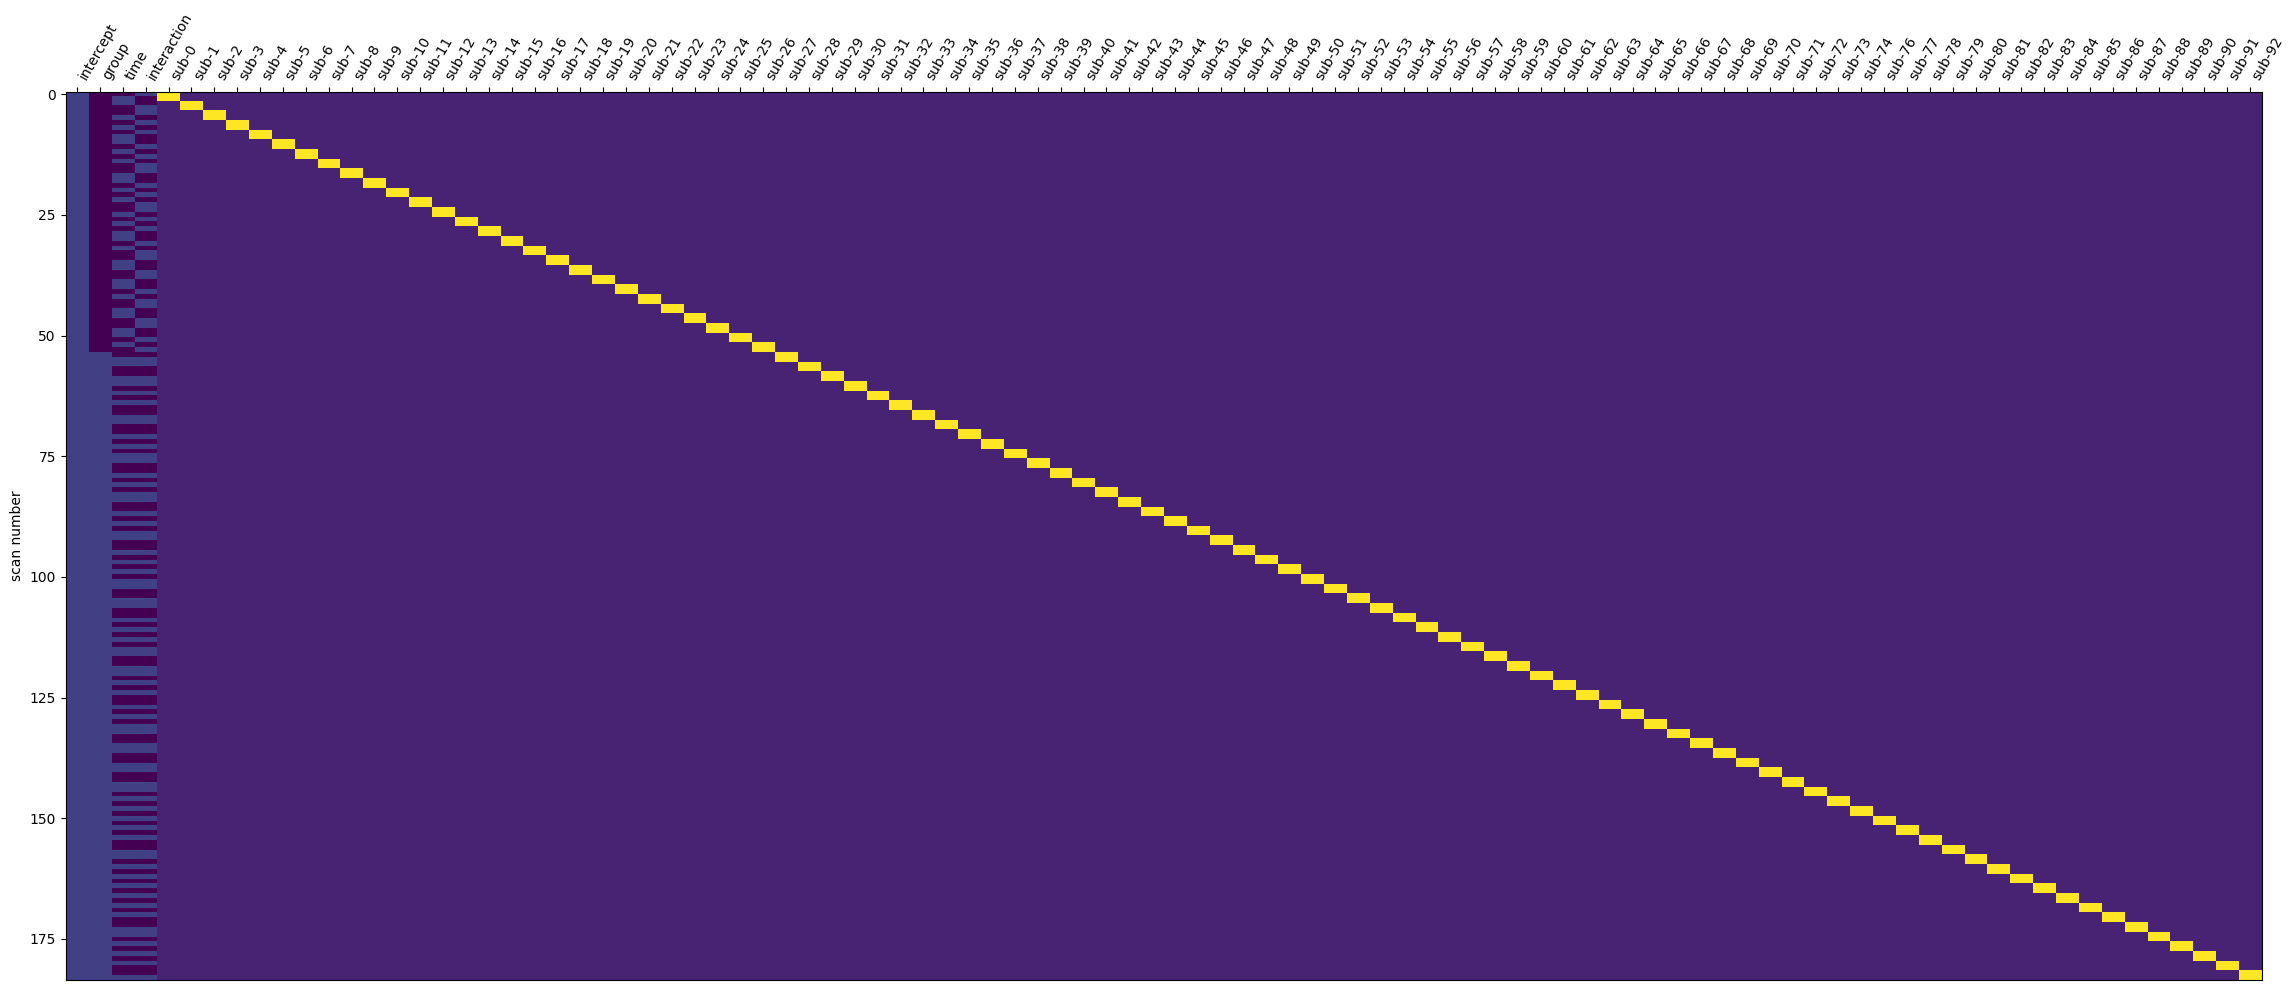

In [6]:
plotting.plot_design_matrix(design_matrix)

In [7]:
scans = matrix_dict['scans']

In [60]:
import re
brainmasks_path = [re.sub('con_0001.nii', 'func/*_task-happy_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz', scan) for scan in [re.sub('1stlevel/results/T', 'preprocessed_t', path) for path in  scans]]
brainmasks = [glob.glob(scan)[0] for scan in brainmasks_path]
brainmasks = [image for image in brainmasks if 'sub-B2' in image]
mean_mask = img.mean_img(brainmasks) 

(97, 115, 97)

In [ ]:
group_mask = img.math_img("a>=0.95", a=mean_mask)
plotting.plot_roi(group_mask)

/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


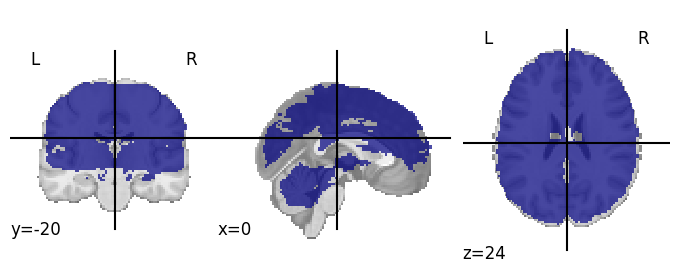

In [74]:
mean_mask = img.mean_img(scans) 
group_mask= img.binarize_img(mean_mask)
plotting.plot_roi(group_mask)

In [75]:
copes_concat = img.concat_imgs(scans, auto_resample=True)
happy_2ndlevel = os.path.join(path, '2ndlevel', 'fsl_test')
copes_concat.to_filename(os.path.join(happy_2ndlevel, 'linear_all_groups.nii.gz'))

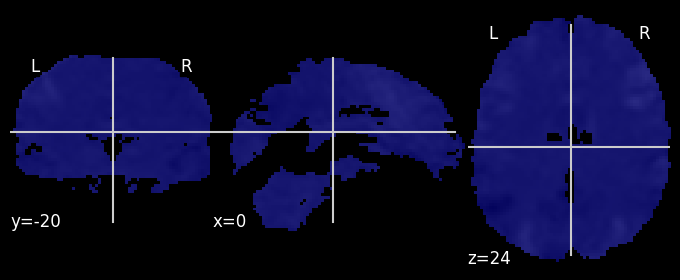

In [76]:
group_mask_sampled = img.resample_to_img(group_mask, copes_concat, interpolation='nearest')
group_mask_sampled.to_filename(os.path.join(happy_2ndlevel, "group_mask.nii.gz"))
plotting.plot_roi(group_mask_sampled, bg_img=img.mean_img(copes_concat))